In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
connflag = False

In [14]:
mqttc = paho.Client()
def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G
    format_date = "%d %b %Y %H%M%S.%f"
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['id']]['state'] = js['state']
    plt, fig = plot(G)
    fig.savefig('figures/{}.png'.format(name))
    plt.close()
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)

mqttc.connect(broker_ip)
mqttc.loop_start()

Connection returned result: 0


In [15]:
mqttc.subscribe('state', 1)


(0, 1)

-t state | -p {"id": 0, "state": "S_a"}
-t state | -p {"id": 0, "state": "S_a"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_s"}
-t state | -p {"id": 0, "state": "S_a"}
-t state | -p {"id": 0, "state": "S_a"}
-t state | -p {"id": 0, "state": "S_s"}


In [16]:
mqttc.loop_stop()

In [13]:
asd = mqttc.publish('start', 'dummy_msg')

In [5]:
def plot(G):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}


    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=(5, 5))
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=12)

    plt.title('step 1')
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    return plt, fig

(0.8035799358443841, 0.7321479615066306) (1, 0)


C:\Users\DFed\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


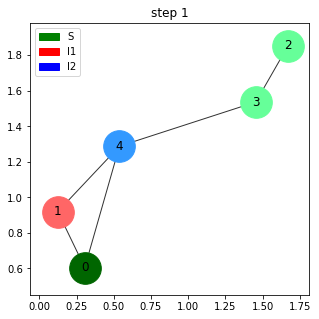

In [6]:
paramet = {
        'alpha': [0.2, 0.15], # infect rate 
        'mu': [0.3, 0.3], # sleep s 
        'gamma': [0.3, 0.3], # rec rate 
        'lambda': [0.1, 0.1], # sleep I1 
        'kappa': [0.2, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(777)
random.seed(3)
N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=1, I2_a=1, grid_size=[2,2], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
G.node[0]['state'] = 'S_s'


plt, fig = plot(G)
# plt.show()
fig.savefig('figures/_.png')

In [12]:
plt.

<module 'matplotlib.pyplot' from 'C:\\Users\\DFed\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'S_s', 'neighbours': [1, 4]}
{'id': 1, 'state': 'I1_a', 'neighbours': [0, 4]}
{'id': 2, 'state': 'S_a', 'neighbours': [3]}
{'id': 3, 'state': 'S_a', 'neighbours': [2, 4]}
{'id': 4, 'state': 'I2_a', 'neighbours': [0, 1, 3]}
